# Advanced ML 3945 HW2

## Install Pakages 

In [1]:
# !pip install umap-learn

## Imports 

In [2]:
# general
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import itertools
import pandas as pd

# projection
from sklearn.manifold import TSNE

# tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split

# metrics
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error

## Set Seed

In [3]:
random_state = 42
np.random.seed(random_state)

## Part 0: Generate Datasets

### Part 0.1: Define Datasets

#### dataset 1:
* class 1 generated from standard normal with mean = 2
* class 0 generated from standard normal with mean = 0

In [4]:
def generate_dataset_1():
    # number of samples per class
    num_samples_per_class = 200

    # generate positive exampels
    negative_features = np.random.randn(num_samples_per_class, 10)
    mean = 2
    positive_features = np.random.randn(num_samples_per_class, 10) + mean

    dataset1_all_features = np.concatenate([negative_features, positive_features])
    dataset1_labels = np.concatenate(
        [np.zeros((num_samples_per_class, 1)), np.ones((num_samples_per_class, 1))]
    )

    return dataset1_all_features, dataset1_labels

In [5]:
dataset1_all_features, dataset1_labels = generate_dataset_1()

In [45]:
dataset1_all_features.shape

(400, 10)

#### dataset 2:
* class 1 generated from point outside to sphere with radius 5
* class 0 generated from point inside  to sphere with radius 5

In [6]:
def generate_dataset_2():
    # Number of samples per class
    num_samples_per_class = 200

    # Sphere parameters
    radius = 5.0
    center = np.array([0, 0, 0])

    # Generate points inside the sphere
    inside_points = np.random.normal(size=(num_samples_per_class, 3))
    inside_points /= np.linalg.norm(
        inside_points, axis=1, keepdims=True
    )  # Normalize vectors
    inside_points *= radius  # Scale by the radius
    inside_points += center  # Translate to the center of the sphere

    # Generate points outside the sphere
    outside_points = np.random.normal(size=(num_samples_per_class, 3))
    outside_points /= np.linalg.norm(
        outside_points, axis=1, keepdims=True
    )  # Normalize vectors
    outside_points *= radius + 1  # Scale by a factor larger than the radius
    outside_points += center  # Translate to the center of the sphere

    # combine points
    # all_features = np.concatenate([inside_points, inside_points]) #TODO<---SHOW OR
    all_features = np.concatenate([inside_points, outside_points])
    dataset2_all_features = np.float32(all_features)
    dataset2_labels = np.concatenate(
        [np.zeros((num_samples_per_class, 1)), np.ones((num_samples_per_class, 1))]
    )

    return dataset2_all_features, dataset2_labels

In [7]:
dataset2_all_features, dataset2_labels = generate_dataset_2()

In [46]:
dataset2_all_features.shape

(400, 3)

### Part 0.2) split dataset into train&test

In [8]:
x1_train, x1_test, y1_train, y1_test = train_test_split(
    dataset1_all_features, dataset1_labels, test_size=0.1, random_state=random_state
)
x2_train, x2_test, y2_train, y2_test = train_test_split(
    dataset2_all_features, dataset2_labels, test_size=0.1, random_state=random_state
)

### Part 0.3: Visualize the datasets

In [9]:
def visualize_dataset_1(dataset1_all_features, dataset1_labels):
    """
    Because the dataset is with high deminsions,
    we will use dimensionality reduction to visualize this dataset
    """
    # set model
    TSNE_model = TSNE(
        n_components=2, learning_rate="auto", init="random", perplexity=10, n_iter=250
    )

    # train model
    projection = TSNE_model.fit_transform(dataset1_all_features)

    # visualize
    plt.figure()
    plt.title("TNSE-2D")
    plt.scatter(
        projection[:, 0], projection[:, 1], c=dataset1_labels, s=30, cmap="Set1"
    )
    plt.grid()
    plt.show()

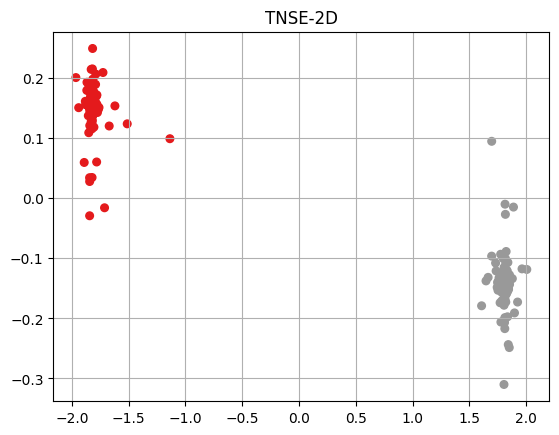

In [10]:
visualize_dataset_1(dataset1_all_features, dataset1_labels)

In [11]:
def visualize_dataset_2(ds2):
    # Plotting the points
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    # num_samples_per_class = 200
    num = 200
    # scatter
    ax.scatter(
        ds2[0:num, 0], ds2[0:num, 1], ds2[0:num, 2], c="b", label="Inside Sphere"
    )
    ax.scatter(
        ds2[num : num * 2, 0],
        ds2[num : num * 2, 1],
        ds2[num : num * 2, 2],
        c="r",
        label="Outside Sphere",
    )
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()
    plt.show()

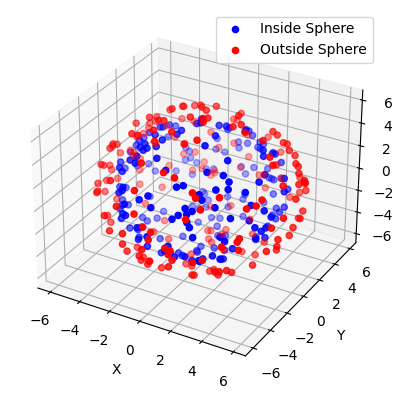

In [12]:
visualize_dataset_2(dataset2_all_features)

## Part 1: Gradient Boosting Regression Trees (GBRT)

### Part 1. 4) Implement GRBT


In [13]:
def calculate_mse(residuals):
    mse = 0.5 * np.mean((residuals) ** 2)
    return mse

In [14]:
class Gradient_Boosting_Regressor:
    def __init__(
        self, n_estimators: int = 100, learning_rate: float = 0.1, max_depth: int = 3
    ):
        # Define model hyper parameters
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth

        # Keep a list to save estimators
        self.estimators = []

        # Set model initial pred
        self.initial_pred = 0.0

        # Keepy a list to track MSE loss during training / fit
        self.MSE_list = []

    def generate_initial_pred(self, y):
        self.initial_pred = np.mean(y)
        self.predictions = np.tile(self.initial_pred, (y.shape[0], 1))

    def fit(self, X, y):
        # generate initial prediction
        self.generate_initial_pred(y)

        # 4b) calculate residual
        residuals = y - self.predictions

        for _ in range(self.n_estimators):
            # 4a) calcualate loss function
            loss = calculate_mse(residuals)

            # 4c) weak regression tree
            # Fit a regression tree to the residuals
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, residuals)

            # Compute the predictions from the tree
            residual_prediction = tree.predict(X)

            # 4d) boosting step
            # Update the residuals by subtracting the predictions
            residuals -= self.learning_rate * np.expand_dims(
                residual_prediction, axis=1
            )

            # Add the tree to the list of estimators
            self.estimators.append(tree)

            # append Mse loss
            self.MSE_list.append(loss)

    def predict(self, X):
        # Initialize the predictions with the initial_pred
        predictions = self.initial_pred * np.ones(X.shape[0])

        # Make predictions using each estimator
        for tree in self.estimators:
            predictions += self.learning_rate * tree.predict(X)

        return predictions

### Part 1. 5&6) Experimenting


#### prepare simulations

In [15]:
def generate_GRBT_expirements():
    """create hyper parameter combinations for
    model hyperparameters grid searching"""
    # Define hyperparameter options
    lr = [1e-3, 1e-2, 1e-1]
    n_estimators = [50, 100, 150]
    max_depth = [1, 2, 3, 4, 5]

    # create HP combinations
    all_combinations = [lr, n_estimators, max_depth]
    all_combinations = list(itertools.product(*all_combinations))
    return all_combinations

#### run sumulation on dataset1

In [16]:
def perform_grid_search_on_GBRT_hyperparameters(X_train, y_train, X_test, y_test):
    expirements_results = []
    mse_expirements_results = []

    GRBT_combination = generate_GRBT_expirements()

    for lr, n_estimators, max_depth in GRBT_combination:
        iteration_results = []

        # set model
        gradient_boosting_classifier = Gradient_Boosting_Regressor(
            n_estimators=n_estimators, learning_rate=lr, max_depth=max_depth
        )

        # train model
        gradient_boosting_classifier.fit(X_train, y_train)

        # get loss decreesing list
        MSE_list = gradient_boosting_classifier.MSE_list

        # predict train labels
        y_train_pred = gradient_boosting_classifier.predict(X_train)

        # predict test labels
        y_test_pred = gradient_boosting_classifier.predict(X_test)

        # set expirement name
        name = (
            "lr_"
            + str(lr)
            + "_n_estimators_"
            + str(n_estimators)
            + "_max_depth_"
            + str(max_depth)
        )

        # append training loss as function of estimator
        mse_expirements_results.append([name, MSE_list])

        # calculate metric and loss
        train_loss = calculate_mse(y_train - y_train_pred)
        test_loss = calculate_mse(y_test - y_test_pred)

        # save current iteratio results
        iteration_results = {
            "expirement_name": name,
            "lr": lr,
            "n_estimators": n_estimators,
            "max_depth": max_depth,
            "train_loss": train_loss,
            "test_loss": test_loss,
        }

        expirements_results.append(iteration_results)

    # finish the loop over all combinations
    # prepare a dtaframe with the results
    results_columns_names = [
        "expirement_name",
        "lr",
        "n_estimators",
        "max_depth",
        "train_loss",
        "test_loss",
    ]
    df = pd.DataFrame(expirements_results)
    df = df.sort_values("test_loss", ascending=True)
    df = df.sort_values(
        "train_loss", ascending=True
    )  # TODO: ask OR - when these lines arent together, one runs over the other

    # return expirements_results, mse_expirements_results
    return df, mse_expirements_results

##### display  simulation results
* the v-measure is behave like accuracy in raw 14->2 there is drop in results in v-measure and in test accuracy

TODO: ask OR what is the meaning of th line above

In [17]:
df, mse_expirements_results = perform_grid_search_on_GBRT_hyperparameters(
    X_train=x1_train, y_train=y1_train, X_test=x1_test, y_test=y1_test
)

In [18]:
print(f"Top experiment hyperparameters with the best loss values")
df[0:5]

Top experiment hyperparameters with the best loss values


,expirement_name,lr,n_estimators,max_depth,train_loss,test_loss
0,lr_0.001_n_estimators_50_max_depth_1,0.001,50,1,0.125169,0.125283
1,lr_0.001_n_estimators_50_max_depth_2,0.001,50,2,0.125229,0.125345
2,lr_0.001_n_estimators_50_max_depth_3,0.001,50,3,0.125273,0.125393
3,lr_0.001_n_estimators_50_max_depth_4,0.001,50,4,0.125290,0.125430
4,lr_0.001_n_estimators_50_max_depth_5,0.001,50,5,0.125294,0.125442


##### get best results parameters

In [19]:
lr, n_estimators, max_depth = df.iloc[0][["lr", "n_estimators", "max_depth"]].to_list()
print(
    f"best parameters:\n1) lr = {lr}\n2) n_estimators = {n_estimators}\n3) max_depth = {max_depth}"
)

best parameters:
1) lr = 0.001
2) n_estimators = 50
3) max_depth = 1


##### display loss as fcator of amount of estimators 
* it can be seen that for different parameters the train loss is decrease diffently.
* it can be seen the for specific parameters, mse loss is not decreesing after 20 estimators, while for some the loss decreese even after 150 estimators


In [20]:
def plot_loss_to_estimators(mse_expirements_results):
    plt.figure(figsize=(18, 12))
    for expirement_name, expirements_mse_list in mse_expirements_results:
        plt.plot(
            np.arange(expirements_mse_list.__len__()),
            expirements_mse_list,
            label=expirement_name,
        )
    plt.grid()
    #  plt.title('Loss decreese as factor of amount of estimator per expirements')  #TODO: show or i changed this
    plt.title(
        "Training Loss  .VS. Estimator #\nLoss decreases as the algorithm learns from estimator to estimator"
    )
    plt.xlabel("Estimator #")
    plt.ylabel("Training Loss")
    plt.legend()
    plt.show()

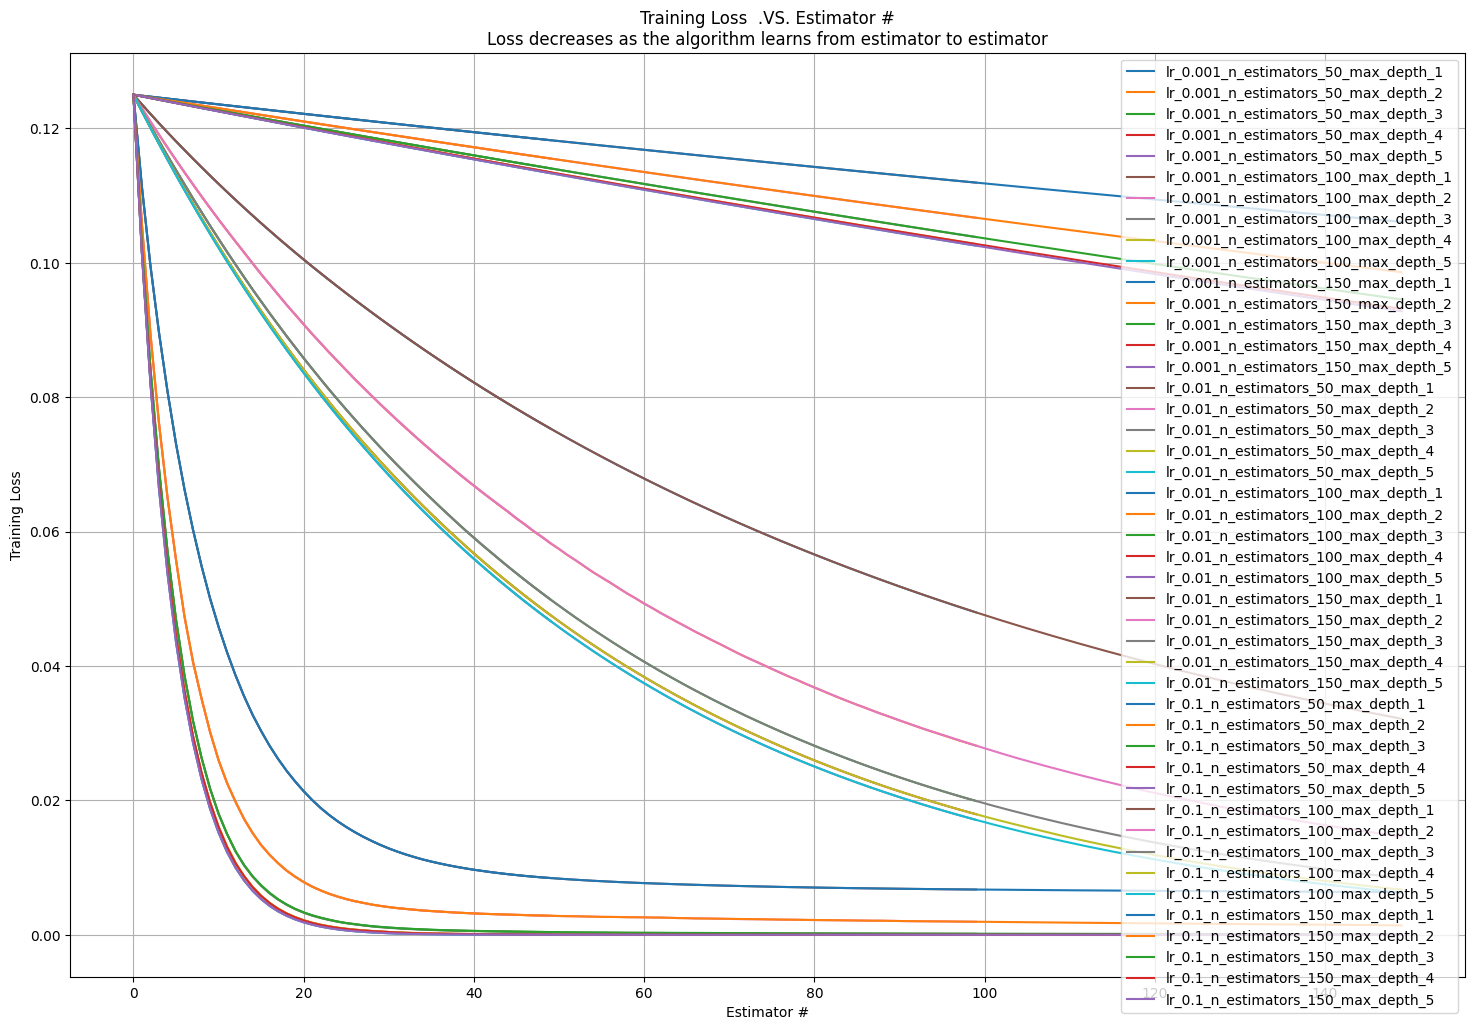

In [21]:
plot_loss_to_estimators(mse_expirements_results)

#### Compare our implementation with the SkLearn implemnentation

In [22]:
def compare_with_sklearn_gbrt_implementation(X_train, y_train, X_test, y_test):
    # Train an sklearn model, and use it to predict
    reg = GradientBoostingRegressor(
        learning_rate=1e-3, n_estimators=50, max_depth=1, random_state=0
    )
    reg.fit(X_train, y_train)
    y_pred_test = reg.predict(X_test)

    # Calculate MSE over residuals
    sklearn_residuals_mse = calculate_mse(y_test - y_pred_test)

    print(
        f"\nThe sklearn implemetation achieved residuals mse loss {sklearn_residuals_mse} when using our best hyperparameters\n"
    )  # TODO: show OR: changed

In [23]:
compare_with_sklearn_gbrt_implementation(
    X_train=x1_train,
    y_train=y1_train,
    X_test=x1_test,
    y_test=y1_test,
)


The sklearn implemetation achieved residuals mse loss 0.1252831957735052 when using our best hyperparameters



/Users/royrubin/opt/anaconda3/envs/mlds/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### run sumulation on dataset2

##### display  simulation results
* the v-measure is behave like accuracy in raw 14->2 there is drop in results in v-measure and in test accuracy

#TODO: ask or, what is the meaning of line abovem me ?

In [24]:
df, mse_expirements_results = perform_grid_search_on_GBRT_hyperparameters(
    X_train=x2_train, y_train=y2_train, X_test=x2_test, y_test=y2_test
)

In [25]:
print(f"Top experiment hyperparameters with the best loss values")
df[0:5]

Top experiment hyperparameters with the best loss values


,expirement_name,lr,n_estimators,max_depth,train_loss,test_loss
0,lr_0.001_n_estimators_50_max_depth_1,0.001,50,1,0.125005,0.125043
5,lr_0.001_n_estimators_100_max_depth_1,0.001,100,1,0.125016,0.125045
1,lr_0.001_n_estimators_50_max_depth_2,0.001,50,2,0.125018,0.125045
10,lr_0.001_n_estimators_150_max_depth_1,0.001,150,1,0.125035,0.125051
2,lr_0.001_n_estimators_50_max_depth_3,0.001,50,3,0.125045,0.125054


##### get best results parameters

In [26]:
lr, n_estimators, max_depth = df.iloc[0][["lr", "n_estimators", "max_depth"]].to_list()
print(
    f"best parameters:\n1) lr = {lr}\n2) n_estimators = {n_estimators}\n3) max_depth = {max_depth}"
)

best parameters:
1) lr = 0.001
2) n_estimators = 50
3) max_depth = 1


##### display loss as fcator of amount of estimators 
* it can be seen that for different parameters the train loss is decrease diffently.
* it can be seen the for specific parameters, mse loss is not decreesing after 20 estimators, while for some the loss decreese even after 150 estimators


In [27]:
# plt.figure(figsize = (18,12))
# for expirement_name, expirements_mse_list in mse_expirements_results:
#    plt.plot(np.arange(expirements_mse_list.__len__()), expirements_mse_list, label =expirement_name )
# plt.grid()
# plt.title('Loss decreese as factor of amount of estimator per expirements')
# plt.legend()

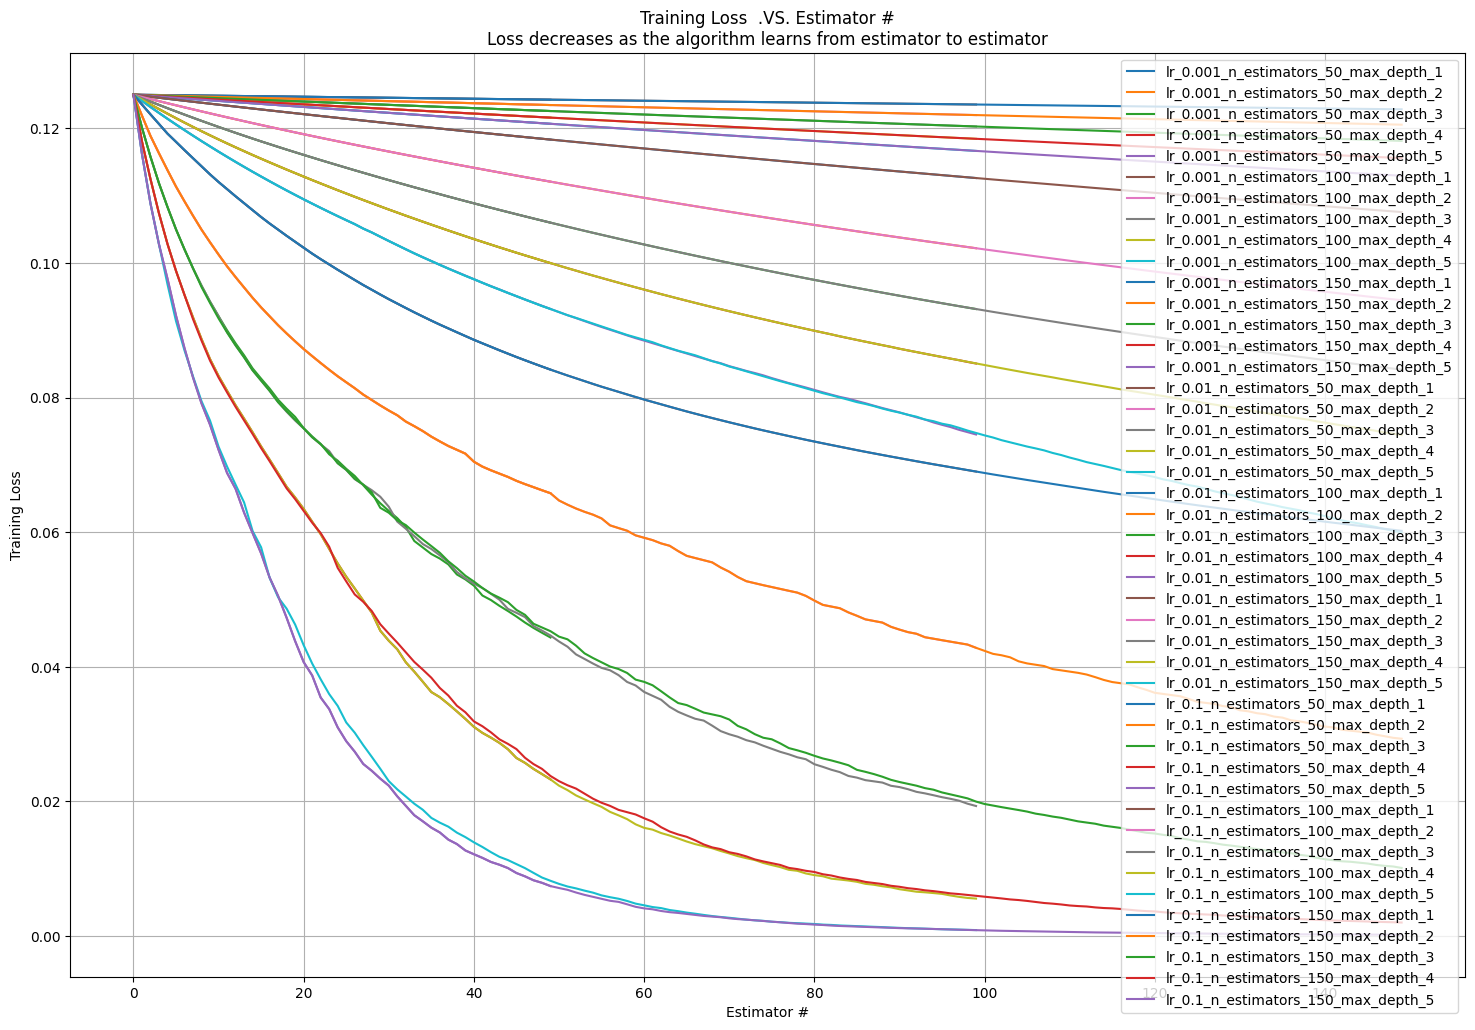

In [28]:
plot_loss_to_estimators(mse_expirements_results)

##### Compare Sklearn implemnentation

In [29]:
compare_with_sklearn_gbrt_implementation(
    X_train=x2_train,
    y_train=y2_train,
    X_test=x2_test,
    y_test=y2_test,
)


The sklearn implemetation achieved residuals mse loss 0.1250428566518638 when using our best hyperparameters



/Users/royrubin/opt/anaconda3/envs/mlds/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Part 2: AdaBoost

### Part 2. 7) Implement adaboost


what is the class below me ?

In [30]:
def evaluate(
    true_labels, predicted_labels, model_name="model", conf_mat=True, print_res=True
):
    
    #TODO: show or: 'y_train_pred' not defined

    accuracy = accuracy_score(y1_train, y_train_pred)
    if print_res:

        #TODO: show OR: "test images" ?

        print(
            f"{model_name} accuracy on {len(predicted_labels)} test images: {accuracy*100:.2f}%"
        )

    if conf_mat:
        mat = confusion_matrix(true_labels, predicted_labels)
        sns.heatmap(mat.T, square=True, annot=True, fmt="d", cbar=False)
        plt.xlabel("true label")
        plt.ylabel("predicted label")
        plt.title("confusion matrix")
        plt.show()

    return accuracy

In [31]:
class Ada_Boost_Classifier:
    def __init__(self, num_estimators, uniform_weight=True):
        # size of forest
        self.num_estimators = num_estimators
        # list of stumps
        self.estimators_list = []
        # list of amount of say
        self.importance_weight_list = []

        self.uniform_weight = uniform_weight

        self.accuracy_list = []

    def generate_weights(self, n):
        """
        generate equal vote for each sample
        """

        # TODO: show OR: this is the same line ?

        if self.uniform_weight:
            sample_weights = np.full(n, 1 / n)
        else:
            sample_weights = np.full(n, 1 / n)
        return sample_weights.reshape(-1, 1)

    def update_weights(
        self, importance_weight, sample_weights, model_error, predictions, y
    ):
        # 7e) boosting step
        temp_ones = np.ones_like(sample_weights)
        temp_ones[np.squeeze(y) == predictions] = -1
        sample_weights *= np.exp(importance_weight * temp_ones.T).T
        # 7f) update weight
        sample_weights /= np.sum(sample_weights)
        return sample_weights

    def calculate_step_size(self, model_error):
        # calculate
        importance_weight = 0.5 * np.log((1 - model_error) / model_error)

        return importance_weight

    def fit(self, X, y):
        # amount of sampels
        n = X.shape[0]

        # 7a
        sample_weights = self.generate_weights(n)
        index_array = np.arange(n)
        for _ in range(self.num_estimators):
            try:
                # 7b -generate decision stump
                estimator = DecisionTreeClassifier(max_depth=1)

                sample_index = [
                    np.random.choice(index_array, p=np.squeeze(sample_weights))
                    for _ in range(n)
                ]

                train_dataset = X[sample_index]
                y_dataset = y[sample_index]

                # train decision stump  #TODO: show OR: use updated sample weights to fit ? Model.fit(X, y, sample_weight = w_i)
                trained_estimator = estimator.fit(train_dataset, y_dataset)

                # get stump predictions
                predictions = trained_estimator.predict(train_dataset)

                # update sample weights
                sample_weights = self.generate_weights(n)

                # 7c) calculate model train errors
                model_error = np.sum(sample_weights.T * (predictions != y_dataset.T))

                # 7d) calculate step size - alpha
                importance_weight = self.calculate_step_size(model_error)

                # 7-e+f) calculate new weight after current tree predicitons
                sample_weights = self.update_weights(
                    importance_weight,
                    sample_weights,
                    model_error,
                    predictions,
                    y_dataset,
                )

                # append current stump
                self.estimators_list.append(trained_estimator)

                # append calculated
                self.importance_weight_list.append(importance_weight)

                # TODO: ask OR: this is not defined yet... ?
                y_pred = ada_boost_classifier.predict(X)
                training_accuracy_score = accuracy_score(y, y_pred)
                self.accuracy_list.append(training_accuracy_score)

            # TODO: ask OR: what is this exception clause ?
            except:
                a = 5

    def predict(self, X):
        # initilized perdiciton as factor of amount of sampels
        predictions = np.zeros(X.shape[0])

        # run prediction over all stumps trre's
        for estimator, importance_weight in zip(
            self.estimators_list, self.importance_weight_list
        ):
            # prediction steps
            curr_predictions = estimator.predict(X)
            curr_predictions[curr_predictions == 0] = -1
            predictions += importance_weight * curr_predictions

        predictions[predictions >= 0] = 1
        predictions[predictions < 0] = 0

        return predictions

#### prepare simulations

In [32]:
def generate_adaboost_expirements():
    # lr = [1e-5,1e-4,1e-3,1e-2,1e-1]
    n_estimators = [5, 10, 15, 30, 50, 100, 200, 500, 1000]

    all_combinations = [n_estimators]
    all_combinations = list(itertools.product(*all_combinations))
    return all_combinations


results_columns_names = [
    "expirement_name",
    "n_estimators",
    "train_accuracy",
    "test_accuracy",
]

adaboost_combination = generate_adaboost_expirements()

#### run sumulation on dataset1

In [33]:
expirements_results = []
accuracy_expirements_results = []

for n_estimators in adaboost_combination:
    n_estimators = n_estimators[0]
    results = []

    # set model
    ada_boost_classifier = Ada_Boost_Classifier(num_estimators=n_estimators)

    # train model
    ada_boost_classifier.fit(x1_train, y1_train)

    # get loss decreesing list
    accuracy_list = ada_boost_classifier.accuracy_list

    # predict train labels
    y_train_pred = ada_boost_classifier.predict(x1_train)

    # predict test labels
    y_test_pred = ada_boost_classifier.predict(x1_test)

    # set expirement name
    name = "n_estimators_" + str(n_estimators)

    # append training loss as function of estimator
    accuracy_expirements_results.append([name, accuracy_list])

    # append parameters
    results += [name, n_estimators]

    # calculate metric and loss
    train_accuracy = accuracy_score(y1_train, y_train_pred)
    test_accuracy = accuracy_score(y1_test, y_test_pred)

    # append metric\loss results
    results += [train_accuracy, test_accuracy]

    expirements_results.append(results)

# clusters metric
df = pd.DataFrame(expirements_results, columns=results_columns_names)
df = df.sort_values("test_accuracy", ascending=False)

##### display  simulation results
* the v-measure is behave like accuracy in raw 14->2 there is drop in results in v-measure and in test accuracy

In [34]:
df[0:50]

,expirement_name,n_estimators,train_accuracy,test_accuracy
1,n_estimators_10,10,0.969444,0.950
3,n_estimators_30,30,0.972222,0.950
4,n_estimators_50,50,0.980556,0.950
2,n_estimators_15,15,0.986111,0.925
5,n_estimators_100,100,0.980556,0.925
6,n_estimators_200,200,0.988889,0.925
7,n_estimators_500,500,0.980556,0.925
8,n_estimators_1000,1000,0.980556,0.925
0,n_estimators_5,5,0.933333,0.850


##### get best results parameters

In [35]:
n_estimators = df.iloc[0][["n_estimators"]].to_list()[0]
print(f"best parameters: \n1) n_estimators = {n_estimators}")

best parameters: 
1) n_estimators = 10


##### display loss as fcator of amount of estimators 
* it can be seen that for different parameters the train loss is decrease diffently.
* it can be seen the for specific parameters, mse loss is not decreesing after 20 estimators, while for some the loss decreese even after 150 estimators


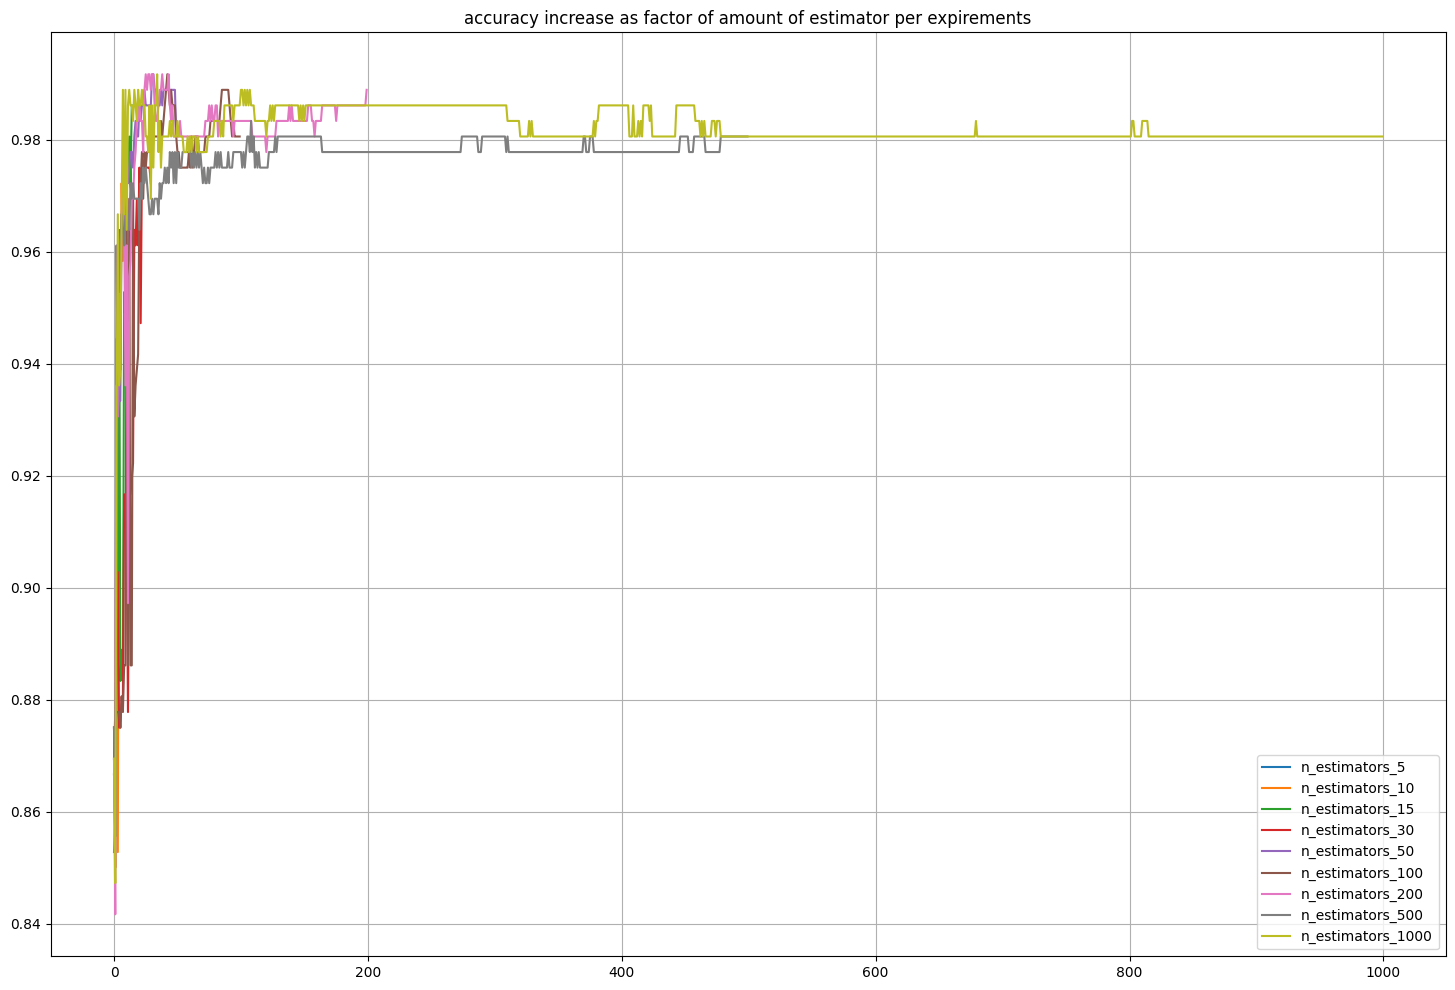

In [36]:
plt.figure(figsize=(18, 12))
for expirement_name, expirements_accuracy_list in accuracy_expirements_results:
    plt.plot(
        np.arange(expirements_accuracy_list.__len__()),
        expirements_accuracy_list,
        label=expirement_name,
    )
plt.grid()
plt.title("accuracy increase as factor of amount of estimator per expirements")
plt.legend()

##### diplay confusion matrix

model accuracy on 40 test images: 98.06%


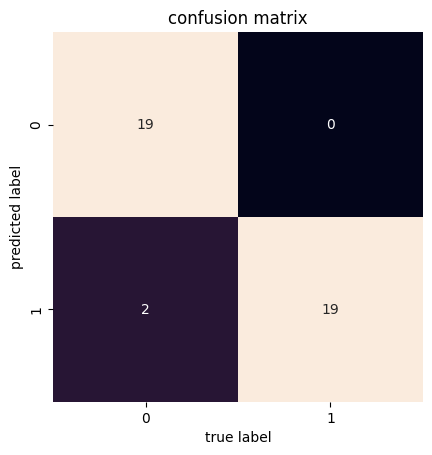

0.9805555555555555

In [37]:
# set model
ada_boost_classifier = Ada_Boost_Classifier(num_estimators=n_estimators)

# train model
ada_boost_classifier.fit(x1_train, y1_train)


# get loss decreesing list
accuracy_list = ada_boost_classifier.accuracy_list

# predict train labels
y_test_pred = ada_boost_classifier.predict(x1_test)


evaluate(y1_test, y_test_pred, model_name="model", conf_mat=True, print_res=True)

##### comapre to sklearn implementation

model accuracy on 40 test images: 98.06%


/Users/royrubin/opt/anaconda3/envs/mlds/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


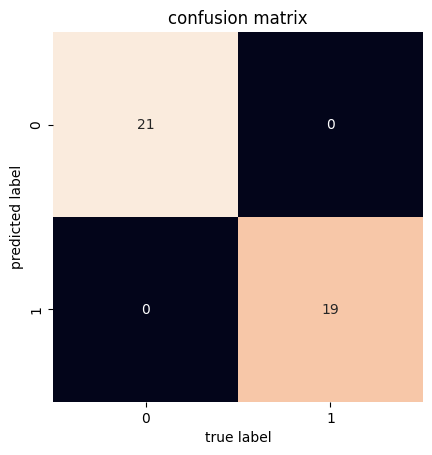

In [38]:
clf = AdaBoostClassifier(n_estimators=n_estimators, random_state=0)
clf.fit(x1_train.tolist(), y1_train.tolist())
y_test_pred = clf.predict(x1_test.tolist())
accuracy = evaluate(
    y1_test, y_test_pred, model_name="model", conf_mat=True, print_res=True
)

#### comapre to sklearn implementation

#### run sumulation on dataset1

In [39]:
expirements_results = []
accuracy_expirements_results = []

for n_estimators in adaboost_combination:
    n_estimators = n_estimators[0]
    results = []

    # set model
    ada_boost_classifier = Ada_Boost_Classifier(num_estimators=n_estimators)

    # train model
    ada_boost_classifier.fit(x2_train, y2_train)

    # get loss decreesing list
    accuracy_list = ada_boost_classifier.accuracy_list

    # predict train labels
    y_train_pred = ada_boost_classifier.predict(x2_train)

    # predict test labels
    y_test_pred = ada_boost_classifier.predict(x2_test)

    # set expirement name
    name = "n_estimators_" + str(n_estimators)

    # append training loss as function of estimator
    accuracy_expirements_results.append([name, accuracy_list])

    # append parameters
    results += [name, n_estimators]

    # calculate metric and loss
    train_accuracy = accuracy_score(y2_train, y_train_pred)
    test_accuracy = accuracy_score(y2_test, y_test_pred)

    # append metric\loss results
    results += [train_accuracy, test_accuracy]

    expirements_results.append(results)

# clusters metric
df = pd.DataFrame(expirements_results, columns=results_columns_names)
df = df.sort_values("test_accuracy", ascending=False)

##### display  simulation results
* the v-measure is behave like accuracy in raw 14->2 there is drop in results in v-measure and in test accuracy

In [40]:
df[0:50]

,expirement_name,n_estimators,train_accuracy,test_accuracy
0,n_estimators_5,5,0.555556,0.550
1,n_estimators_10,10,0.561111,0.525
2,n_estimators_15,15,0.497222,0.525
3,n_estimators_30,30,0.497222,0.525
4,n_estimators_50,50,0.497222,0.525
5,n_estimators_100,100,0.497222,0.525
6,n_estimators_200,200,0.497222,0.525
7,n_estimators_500,500,0.497222,0.525
8,n_estimators_1000,1000,0.497222,0.525


In [41]:
n_estimators = df.iloc[0][["n_estimators"]].to_list()[0]
print(f"best parameters: \n1) n_estimators = {n_estimators}")

best parameters: 
1) n_estimators = 5


##### display loss as fcator of amount of estimators 
* it can be seen that for different parameters the train loss is decrease diffently.
* it can be seen the for specific parameters, mse loss is not decreesing after 20 estimators, while for some the loss decreese even after 150 estimators


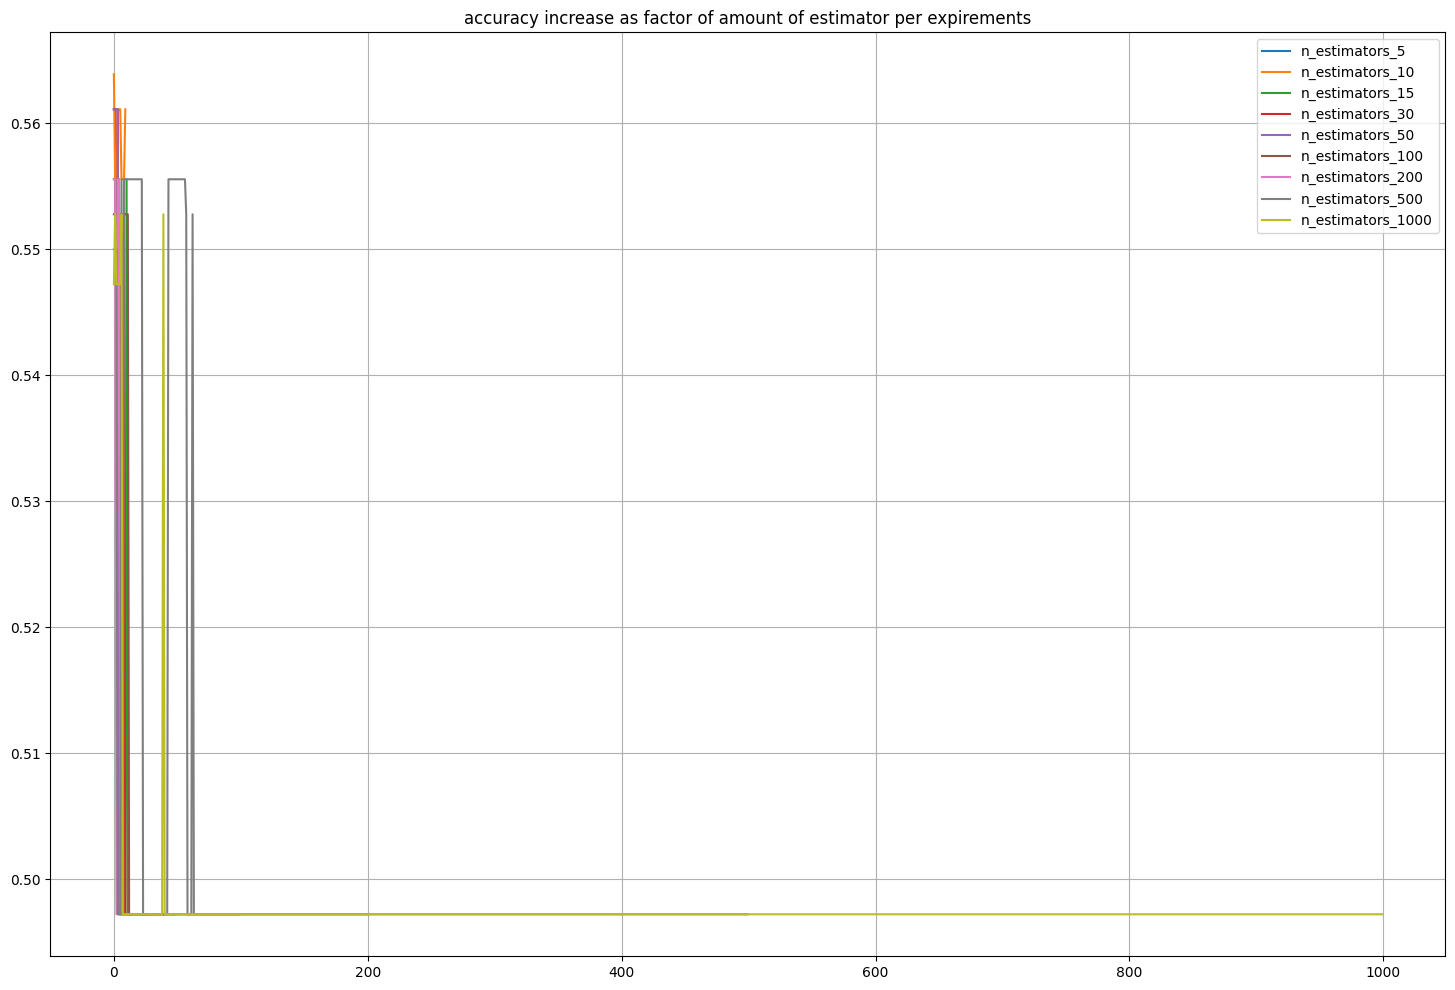

In [42]:
plt.figure(figsize=(18, 12))
for expirement_name, expirements_accuracy_list in accuracy_expirements_results:
    plt.plot(
        np.arange(expirements_accuracy_list.__len__()),
        expirements_accuracy_list,
        label=expirement_name,
    )
plt.grid()
plt.title("accuracy increase as factor of amount of estimator per expirements")
plt.legend()

##### diplay confusion matrix

model accuracy on 40 test images: 49.72%


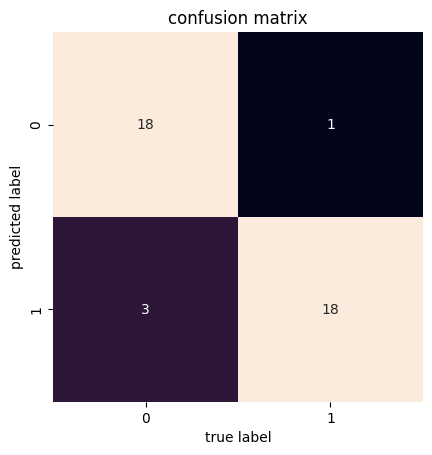

In [43]:
# set model
ada_boost_classifier = Ada_Boost_Classifier(num_estimators=n_estimators)

# train model
ada_boost_classifier.fit(x1_train, y1_train)


# get loss decreesing list
accuracy_list = ada_boost_classifier.accuracy_list

# predict train labels
y_test_pred = ada_boost_classifier.predict(x1_test)


accuracy = evaluate(
    y2_test, y_test_pred, model_name="model", conf_mat=True, print_res=True
)

##### comapre to sklearn implementation

model accuracy on 40 test images: 49.72%


/Users/royrubin/opt/anaconda3/envs/mlds/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


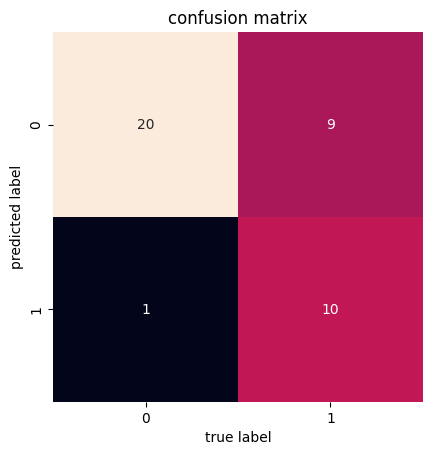

0.49722222222222223

In [44]:
clf = AdaBoostClassifier(n_estimators=n_estimators, random_state=0)
clf.fit(x2_train.tolist(), y2_train.tolist())
y_test_pred = clf.predict(x2_test.tolist())
evaluate(y2_test, y_test_pred, model_name="model", conf_mat=True, print_res=True)

# Part 4: Summary

## part 0 - Part 0: Load the data
* in this part we generate 2 datasets
  * first one is standard normal with 2 different mean with 10 features, with 2 different class 0/1
  * secound we define sphere, point inside the sphere is belong to class 0, and the outside point belong to class 1
* the amount of sampels is 400 overall, and the data is balanced between the class
* split data to train & test 90% fro training and 10% for testing
  * we split data base on label data in order that test data will same amount of labels per class same as in train data in order to generlized
* we visualized the dataset1 after dimention reduction due to the fact amount of feature is 10, and it is easyer to visualyzed in 2D
* we visualized dataset2 in 3D base on the dataset.



## Part 1: Gradient Boosting Regression Trees (GBRT)
* in this part we tried to use Implement GBRT
* we define our expirments, running sumulation for all combination for the following options:
  * lr = [1e-5,1e-4,1e-3,1e-2,1e-1]
  * n_estimators = [50,100,150]
  *  max_depth =  [1,2,3,4,5]
* we run the simulation on the 2 dataset we generate in part 0
* for each dataset we diplay the MSE loss as function of amount of tree's
  * it can be seen from the plot that exist parameters, which the loss decreese in monoton way, while exist parameters where after 20 trees, model is stop to be improve
* the best parameters for this sucssion is:
 * for dataset1
    * lr = 1e-05
    * n_estimators = 50
    * max_depth = 1
  * for dataset1
    * lr = 1e-05
    * n_estimators = 50
    * max_depth = 1
* for those expirements, we understand that the learning rate, is crucial for model converge for our specific data, however if was design more complex dataset maybe the amount of trees\max depth could take a place in converges of methood.
* we compare our implementation to sklearn results
  * our implementation achieve
    * dataset1 - 
    * dataset2 -
  * sklearn achieve:
    * dataset1
    * dataset2
     





## Part 2: Part 2: AdaBoost
* in this part we tried to use Implement adaboost
* we define our expirments, running sumulation for all combination for the following options:
  * n_estimators = [5,10,15,30,50,100,200,500,1000]

* we run the simulation on the 2 dataset we generate in part 0
* for each dataset we diplay the Accuracy as function of amount of tree's
  * it can be seen from the plot that exist parameters, which the accuracy increase different way, for each simulation the method enter into satoration mode in different amount of tree's
* the best parameters for this sucssion is:
 * for dataset1
    * lr = 1e-05
    * n_estimators = 50
    * max_depth = 1
  * for dataset1
    * lr = 1e-05
    * n_estimators = 50
    * max_depth = 1
* for those expirements, due to the fact we use stump as our tree, the amount of tree required for hihg accuracy results is greater than GBRT
* we compare our implementation to sklearn results
  * our implementation achieve
    * dataset1 - 
    * dataset2 -
  * sklearn achieve:
    * dataset1 - 
    * dataset2 - 


